## Imports

In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
def math_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [3]:
TSPA_PATH = "../data/TSPA.csv"
TSPB_PATH = "../data/TSPB.csv"

## Read Data

In [4]:
df = pd.read_csv(TSPA_PATH, sep=";", header=None)
df.columns = ["x", "y", "val"]
df

,x,y,val
0,1355,1796,496
1,2524,387,414
2,2769,430,500
3,3131,1199,1133
4,661,87,903
...,...,...,...
195,189,1151,1145
196,3688,759,727
197,973,984,1637
198,910,1383,1255


## Utils

In [45]:
def plot_nodes_with_lines(df, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))

    # Normalize the values for color mapping (higher values are worse)
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))  # Use Reds colormap (higher values are redder/worse)

    # Plotting the points with color based on value
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    # Drawing lines between specified connections
    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        # Optionally close the loop, if connections should be cyclic
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')

    # Adding color bar to represent the value scale
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Nodes with Color-Scaled Values' if connections is None else 'Nodes with Values and Connections'
    plt.title(title)
    plt.grid(False)
    plt.show()


def get_distance_matrix(df, distance_function):
    """
    Calculates the distance matrix for a set of nodes using the given distance function.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    distance_function: function that takes two points (x1, y1) and (x2, y2) and returns the distance.

    Returns:
    A 2D numpy array representing the distance matrix.
    """
    positions = df[["x", "y"]]
    num_nodes = len(positions)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int64)

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            dist = round(distance_function(positions.iloc[i], positions.iloc[j]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    return distance_matrix

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)
    # return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

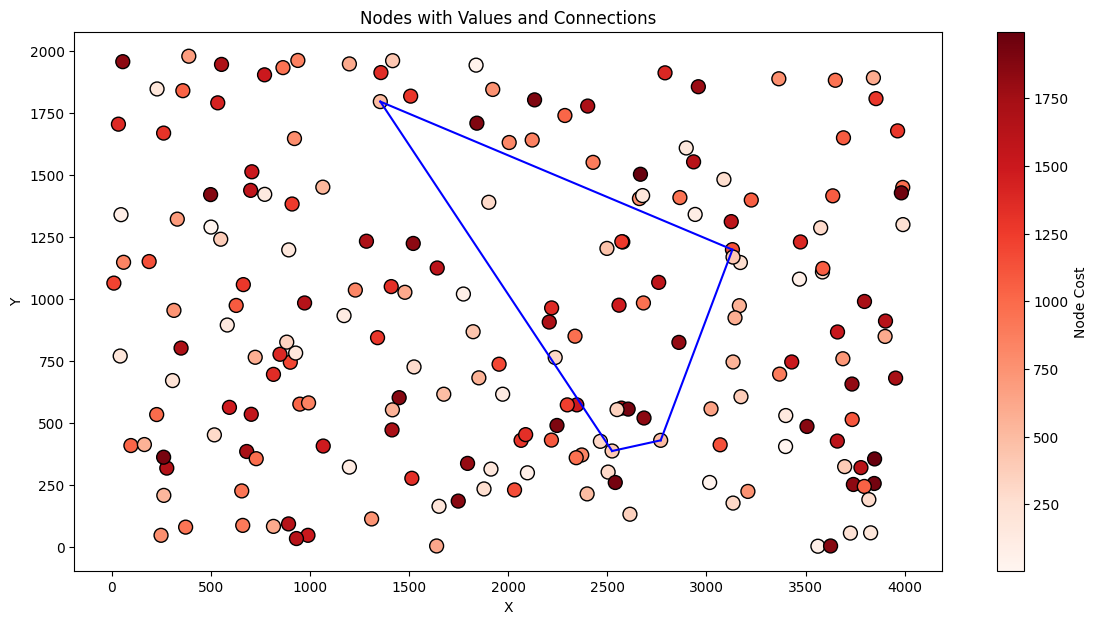

In [46]:
plot_nodes_with_lines(df, [0,1,2,3])

In [47]:
distance_matrix = get_distance_matrix(df, euclidean_distance)
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,1831,1966,1874,1845,1097,1658,2297,2193,1364,...,1977,746,1414,993,1527,1333,2553,897,607,1100
1,1831,0,249,1014,1887,1985,802,1872,1270,1027,...,2173,2104,2213,2215,1016,2457,1222,1662,1897,2600
2,1966,249,0,850,2136,2209,1050,1698,1066,981,...,2421,2301,2447,2426,1264,2679,976,1880,2089,2796
3,1874,1014,850,0,2709,2513,1715,858,344,512,...,2976,2442,2809,2632,1861,2942,710,2169,2229,2907
4,1845,1887,2136,2709,0,888,1091,3487,3036,2396,...,288,1352,780,1214,874,1164,3101,950,1320,1632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1333,2457,2679,2942,1164,473,1834,3537,3286,2486,...,1087,587,384,342,1587,0,3521,802,757,523
196,2553,1222,976,710,3101,3068,2023,1124,517,1212,...,3384,3063,3338,3231,2227,3521,0,2724,2847,3545
197,897,1662,1880,2169,950,345,1113,2824,2513,1741,...,1085,529,649,563,890,802,2724,0,404,987
198,607,1897,2089,2229,1320,497,1462,2785,2569,1752,...,1409,216,807,419,1260,757,2847,404,0,708


In [48]:
weights = df.val.to_numpy()
weights[:2]

array([496, 414], dtype=int64)

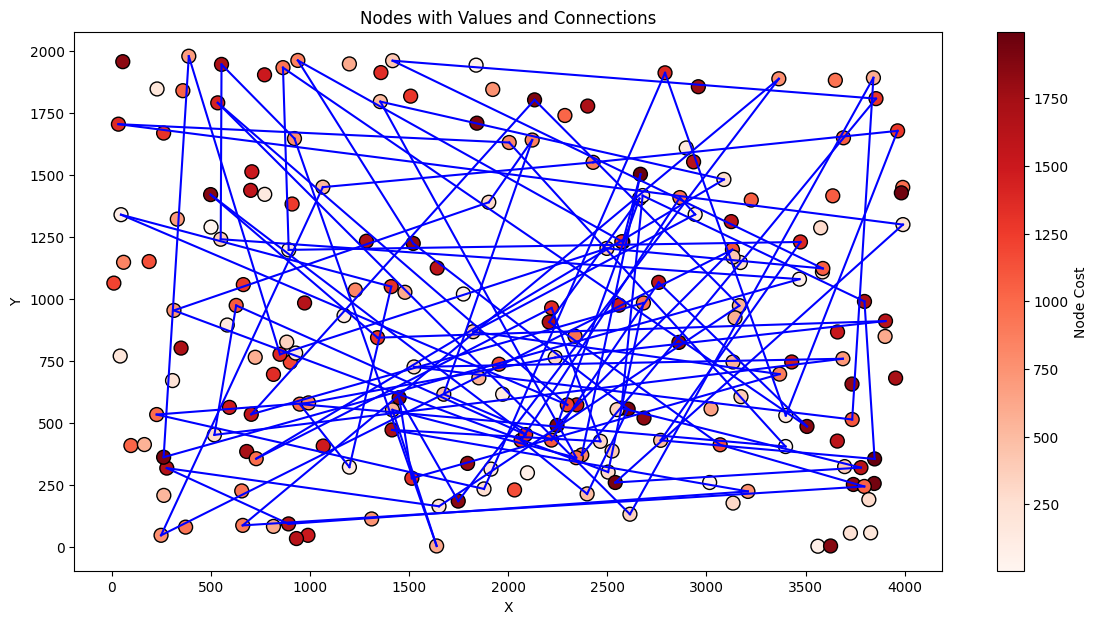

251925

In [49]:
def random_solution(distance_matrix):
    return np.random.choice(range(len(distance_matrix)), len(distance_matrix)//2, replace=False)

sol = random_solution(distance_matrix)
plot_nodes_with_lines(df, sol)
calculate_score(sol, distance_matrix, weights)

In [83]:
def nearest_neighbor_end(distance_matrix, weights, start_node):
    d_matrix = np.copy(distance_matrix)
    d_matrix = d_matrix.astype(np.float64)
    np.fill_diagonal(d_matrix, np.inf)
    num_nodes = d_matrix.shape[0]
    solution = np.zeros(num_nodes//2, dtype=np.int64)

    solution[0] = start_node
    d_matrix[start_node] = np.inf
    
    next_node = start_node
    i = 1
    while i < num_nodes//2:
        next_node = np.argmin(d_matrix[:, next_node] + weights)
        d_matrix[next_node] = np.inf
        solution[i] = next_node
        i += 1

    score = calculate_score(solution, distance_matrix, weights)
    return solution, score


def nearest_neighbor_all(distance_matrix, weights, start_node):
    d_matrix = np.copy(distance_matrix)
    d_matrix = d_matrix.astype(np.float64)
    np.fill_diagonal(d_matrix, np.inf)
    num_nodes = d_matrix.shape[0]

    d_matrix[start_node] = np.inf
    
    solution = [start_node]

    i = 1
    while i < num_nodes//2:
        j = 0
        best_found = np.inf
        insert_node_idx = None
        insert_node_nearest = None    

        while j < i:
            tested_node = solution[j]

            nearest_node = np.argmin(d_matrix[:, tested_node] + weights)
            min_cost = d_matrix[:, tested_node][nearest_node] + weights[nearest_node]

            if min_cost < best_found:
                best_found = min_cost
                insert_node_idx = j+1
                insert_node_nearest = nearest_node            

            j += 1

        d_matrix[insert_node_nearest] = np.inf
        solution.insert(insert_node_idx, insert_node_nearest)

        i += 1

    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [99]:
# start_node = np.random.randint(0, len(distance_matrix))
df['distance'] = np.sqrt(df['x']**2 + df['y']**2)
    
# Get the row with the minimum distance
start_node = df.iloc[df['distance'].idxmin()].name
start_node

10

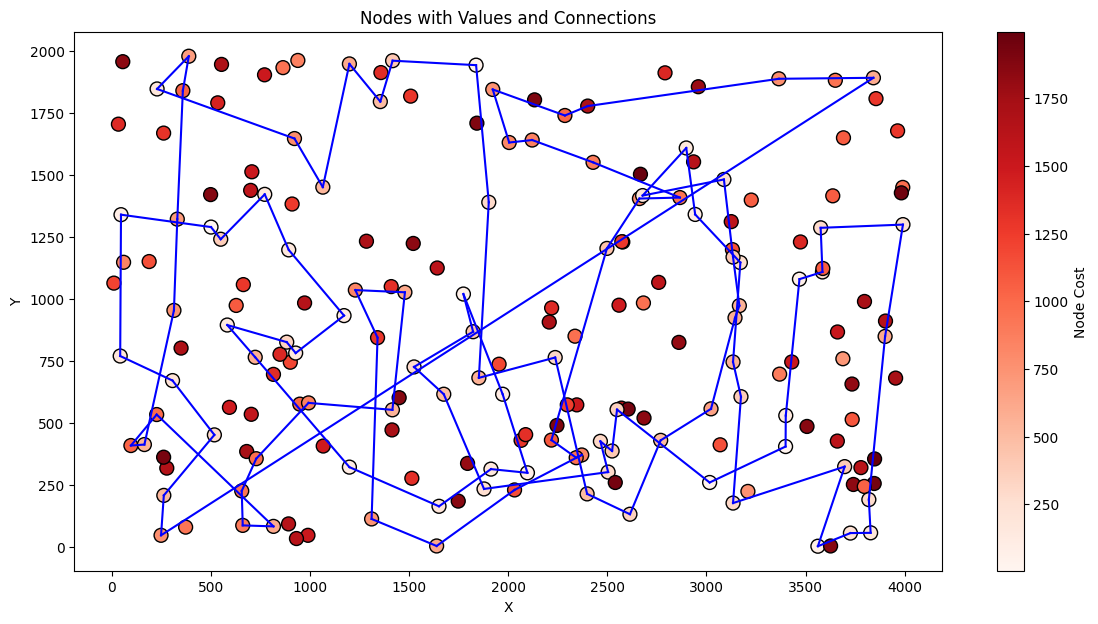

(x           249.000000
 y            47.000000
 val         774.000000
 distance    253.396922
 Name: 10, dtype: float64,
 86282)

In [100]:
sol, score = nearest_neighbor_end(distance_matrix, weights, start_node)
plot_nodes_with_lines(df, sol)
df.iloc[start_node], score

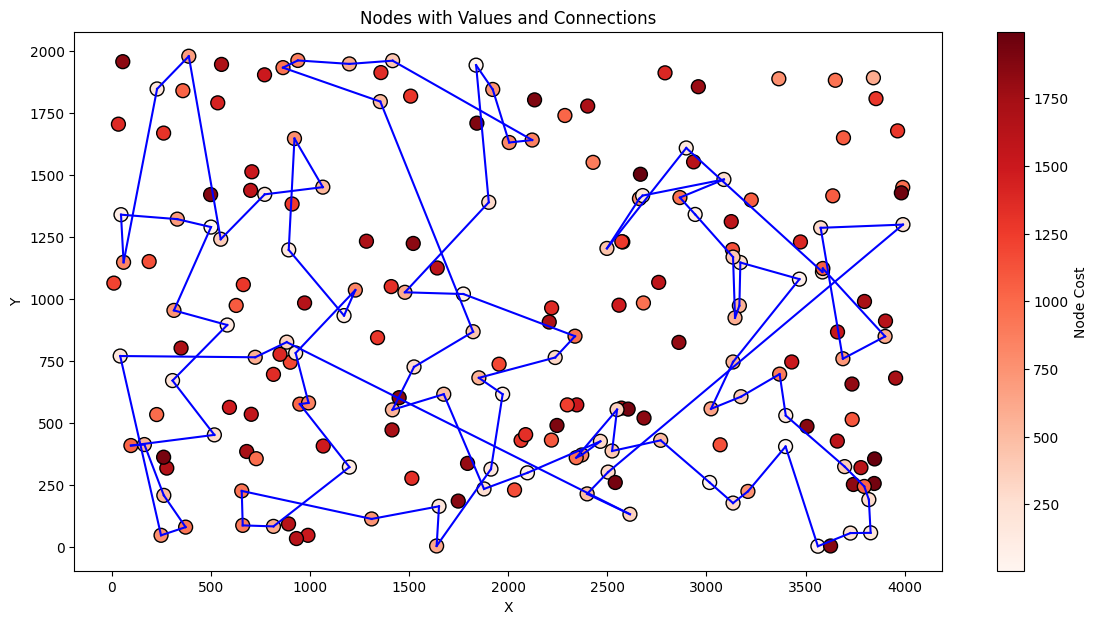

(x           249.000000
 y            47.000000
 val         774.000000
 distance    253.396922
 Name: 10, dtype: float64,
 80443)

In [101]:
# start_node = np.random.randint(0, len(distance_matrix))
sol, score = nearest_neighbor_all(distance_matrix, weights, start_node)
plot_nodes_with_lines(df, sol)
df.iloc[start_node], score

In [66]:
def greedy_cycle(matrix, weights):
    distance_matrix = np.copy(matrix)
    np.fill_diagonal(distance_matrix, np.inf)
    solution = []
    num_nodes = distance_matrix.shape[0]
    score = 0

    starting_node = np.random.randint(num_nodes)
    distance_matrix[starting_node] = np.inf
    second_node = np.argmin(distance_matrix[:, starting_node] + weights)
    distance_matrix[second_node] = np.inf
    third_node = np.argmin(distance_matrix[:, starting_node] + distance_matrix[:, second_node] + weights)
    distance_matrix[third_node] = np.inf
    solution = [starting_node, second_node, third_node]
    score = calculate_score(solution, matrix, weights)

    num_iterations = round(num_nodes*0.5)-3
    for i in range(num_iterations):
        best_score = np.inf
        best_solution = None
        best_node = None
        for ii in range(len(solution)):
            new_score, new_solution, new_node = find_shortest_cycle(distance_matrix, matrix, weights, solution.copy(), ii)
            if new_score < best_score:
                best_score = new_score
                best_solution = new_solution
                best_node = new_node
        solution = best_solution.copy()
        score = best_score
        distance_matrix[best_node] = np.inf

    solution.append(solution[0])
    return solution, score

def calculate_score(solution, matrix, weights):
    score = 0
    for i in range(len(solution)-1):
        node_1 = solution[i]
        node_2 = solution[i+1]
        score += (matrix[node_1][node_2] + weights[node_1])
    node_1 = solution[-1]
    node_2 = solution[0]
    score += (matrix[node_1][node_2] + weights[node_1])
    return score

def find_shortest_cycle(distance_matrix, matrix, weights, solution, idx):
    node_1 = solution[idx-1]
    node_2 = solution[idx]
    new_node = np.argmin(distance_matrix[:, node_1] + distance_matrix[:, node_2] + weights)
    solution.insert(idx, new_node)
    new_score  = calculate_score(solution, matrix, weights)
    return new_score, solution, new_node


solution, score = greedy_cycle(distance_matrix, df["val"].values)

SyntaxError: invalid syntax (660950209.py, line 36)

In [80]:
solution

[25,
 16,
 171,
 175,
 113,
 56,
 31,
 78,
 145,
 179,
 92,
 57,
 52,
 185,
 119,
 40,
 196,
 81,
 90,
 165,
 106,
 178,
 3,
 14,
 144,
 62,
 9,
 148,
 102,
 49,
 55,
 129,
 152,
 97,
 1,
 101,
 100,
 53,
 180,
 154,
 135,
 70,
 127,
 123,
 162,
 149,
 131,
 65,
 116,
 43,
 184,
 35,
 84,
 112,
 4,
 190,
 10,
 177,
 30,
 54,
 48,
 160,
 34,
 146,
 22,
 18,
 108,
 69,
 159,
 181,
 42,
 5,
 41,
 193,
 139,
 68,
 46,
 115,
 59,
 118,
 51,
 151,
 133,
 176,
 0,
 143,
 183,
 89,
 23,
 137,
 80,
 79,
 63,
 94,
 26,
 86,
 75,
 2,
 120,
 44,
 25]

In [81]:
score

72642.4399373738

In [82]:
def math_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [83]:
def create_node_dataframe(nodes_list, original_df, score):
    new_df = original_df.reset_index().rename(columns={'index': 'node'})
    filtered_df = new_df[new_df['node'].isin(nodes_list)]
    filtered_df = filtered_df.set_index('node')
    reordered_df = filtered_df.loc[nodes_list]
    final_df = reordered_df.reset_index()
    score_list = [round(score)]
    score_list += [None for i in range(len(nodes_list)-1)]
    final_df["score"] = score_list
    return final_df

solution_df = create_node_dataframe(solution, df, score)

In [84]:
solution_df

,node,x,y,val,score
0,25,3209,224,756,72642.0
1,16,3562,3,82,NaN
2,171,3726,56,237,NaN
3,175,3828,57,178,NaN
4,113,3819,191,283,NaN
...,...,...,...,...,...
96,75,2614,132,360,NaN
97,2,2769,430,500,NaN
98,120,3016,260,34,NaN
99,44,3134,177,311,NaN


In [85]:
print(sum(solution_df.val))

49234


In [86]:
def calculate_cycle_distance(df):
    # Ensure the DataFrame has the required columns
    if not set(['x', 'y']).issubset(df.columns):
        raise ValueError("The DataFrame must have 'x' and 'y' columns.")

    # Initialize the sum of distances
    total_distance = 0
    
    # Iterate over each node and its next neighbor (including the cycle back to the first)
    num_nodes = len(df)
    
    for i in range(num_nodes):
        # Get the current node and the next node (cycling back to the first for the last node)
        x1, y1 = df.iloc[i]['x'], df.iloc[i]['y']
        x2, y2 = df.iloc[(i + 1) % num_nodes]['x'], df.iloc[(i + 1) % num_nodes]['y']
        
        # Calculate Euclidean distance
        distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        
        # Add the distance to the total
        total_distance += distance
    
    return total_distance

round(calculate_cycle_distance(solution_df))

24164

In [87]:
score -= sum(solution_df.val)
round(score)

23408

In [88]:
solution_df.to_csv("../data/solution.csv", sep=";")

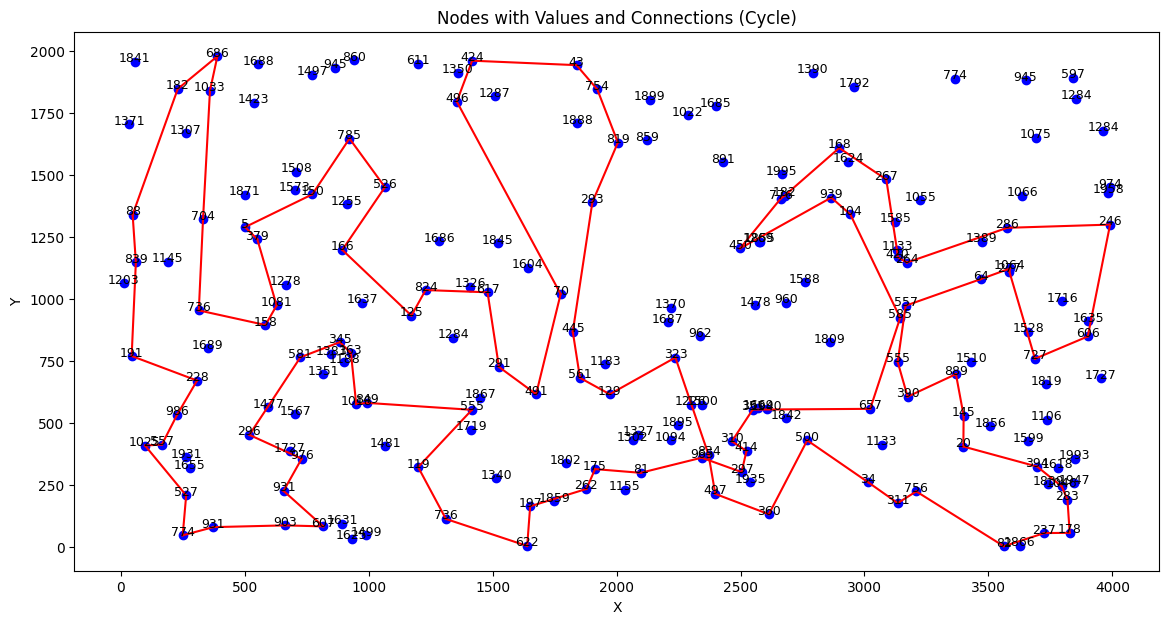

In [89]:
import matplotlib.pyplot as plt

def plot_nodes_with_lines(nodes, connections=None):
    """
    Plots nodes with optional lines connecting them.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node positions in the nodes DataFrame, specifying the order of connections
    """
    plt.figure(figsize=(14, 7))
    plt.scatter(nodes['x'], nodes['y'], color='blue')
    for i in range(len(nodes)):
        plt.text(nodes['x'].iloc[i], nodes['y'].iloc[i] + 0.5, str(nodes['val'].iloc[i]), 
                 ha='center', fontsize=9, color='black')

    if connections:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([nodes['x'].iloc[start], nodes['x'].iloc[end]], 
                     [nodes['y'].iloc[start], nodes['y'].iloc[end]], color='red')
        plt.plot([nodes['x'].iloc[connections[-1]], nodes['x'].iloc[connections[0]]], 
                 [nodes['y'].iloc[connections[-1]], nodes['y'].iloc[connections[0]]], color='red')

    plt.xlabel('X')
    plt.ylabel('Y')
    text = 'Nodes with Values' if not connections else 'Nodes with Values and Connections (Cycle)'
    plt.title(text)
    plt.grid(False)
    plt.show()


plot_nodes_with_lines(df, solution)